# How to combine lightcurves from different Kepler quarters

The Kepler mission took 17 quarters of continuous observations on the same targets. For applications such as finding long period planets or asteroseismology it is useful to be able to turn these quarters into one long light curve. For a small number of pre-processed lightcurves you can simply append lightcurves together, which returns a `KeplerLightCurve`:

    stitched_lc = lc1.append(lc2)
    
For a larger number of lightcurve quarters or sectors, you can use a convenience method `.stitch()` that operates on a `LightCurveCollection` object:

    lc_collection = lk.LightCurveCollection([lc1, lc2])
    stitched_lc = lc_collection.stitch()
    

Below is an example of how to stitch together all the quarters for the exoplanet target Kepler-8b.

In [1]:
import lightkurve as lk

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-8b', mission='Kepler').download_all()

We downloaded all the quarters in one fell swoop, resulting in a collection of `LightCurveFile` objects

In [3]:
lcfs

LightCurveFileCollection of 18 objects:
	KIC 6922244 (18 KeplerLightCurveFiles) Quarters: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

Each of those `LightCurveFile` objects also has PDCSAP and SAP data products available:

In [4]:
lcfs.PDCSAP_FLUX

LightCurveCollection of 18 objects:
	KIC 6922244 (18 KeplerLightCurves) Quarters: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

We can stitch all the lightcurves in the `LightCurveCollection` using the `stitch()` method:

In [5]:
stitched_lc = lcfs.PDCSAP_FLUX.stitch()
stitched_lc

KeplerLightCurve(ID: 6922244)

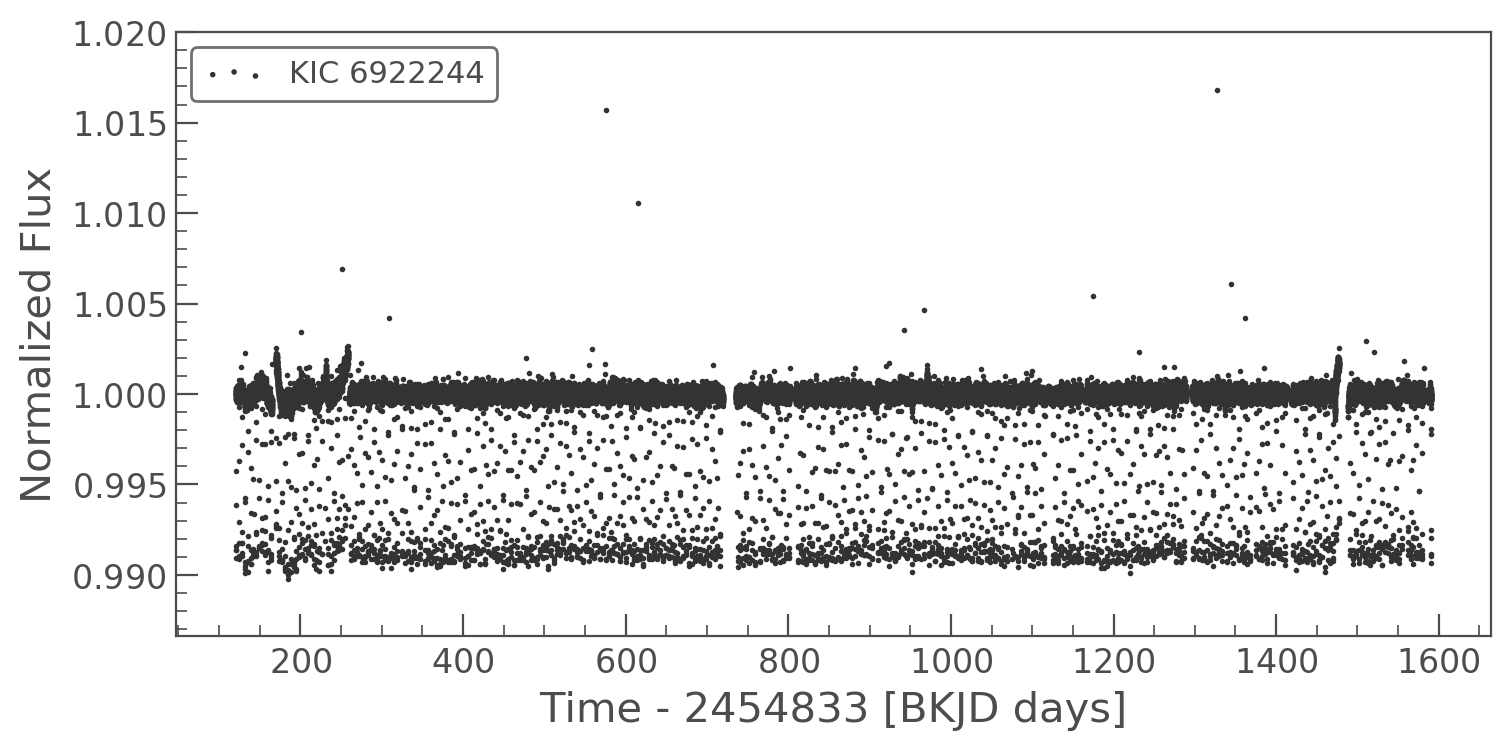

In [6]:
stitched_lc.scatter();

The early quarters of the data show some clear long term wiggle-like trends.  We can remove those wiggles by applying a "corrector function" to each lightcurve segment before stitching.  

The `corrector_func` input is a lightcurve and the output is an optionally processed lightcurve.

In [7]:
def my_custom_corrector_func(lc):
    corrected_lc = lc.normalize().flatten(window_length=401)
    return corrected_lc

In [8]:
stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=my_custom_corrector_func)

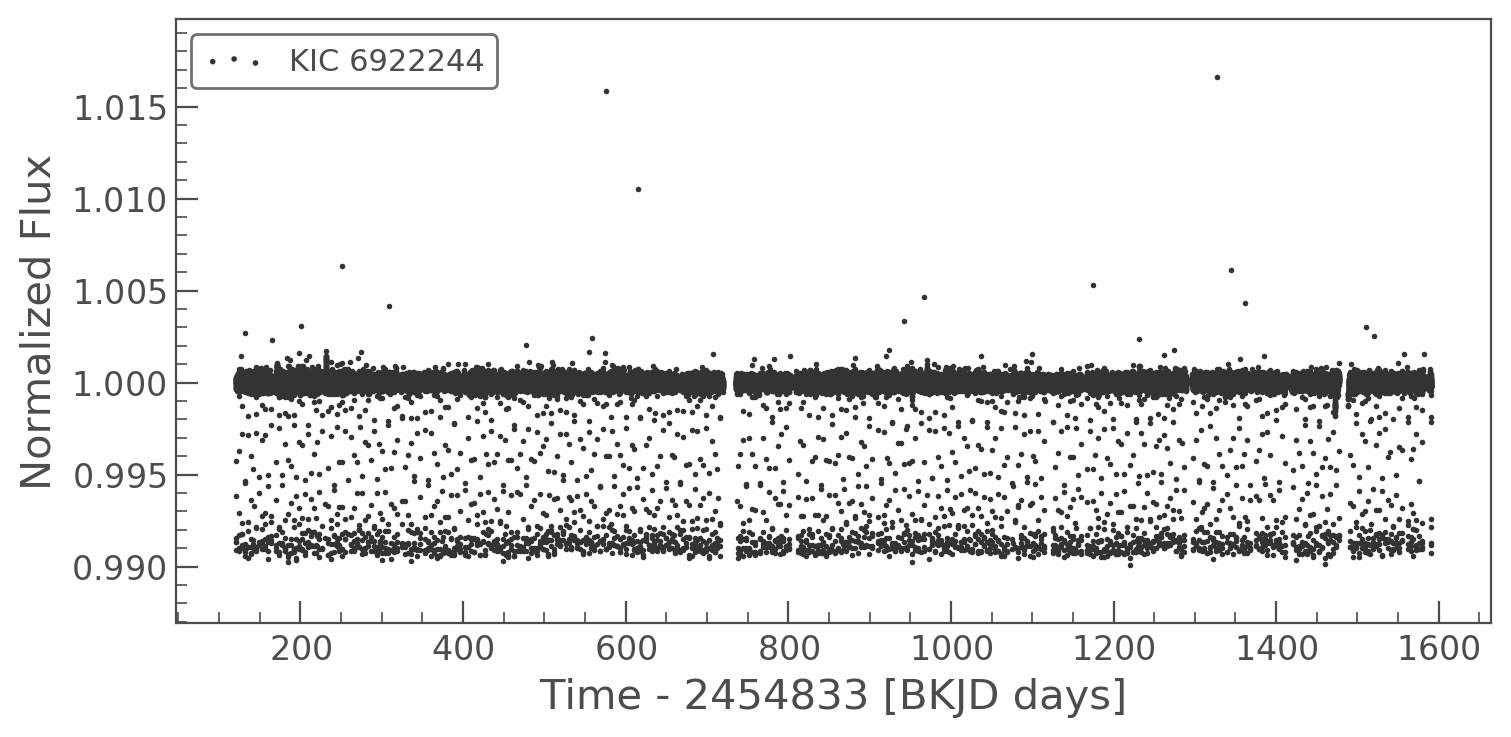

In [9]:
stitched_lc.scatter()

Nice!  The wiggle systematic is gone and all of the light curves stitch together with no visible join. We can use the `fold` and `bin` methods to form a planet transit out of all of the data for Kepler-8b.

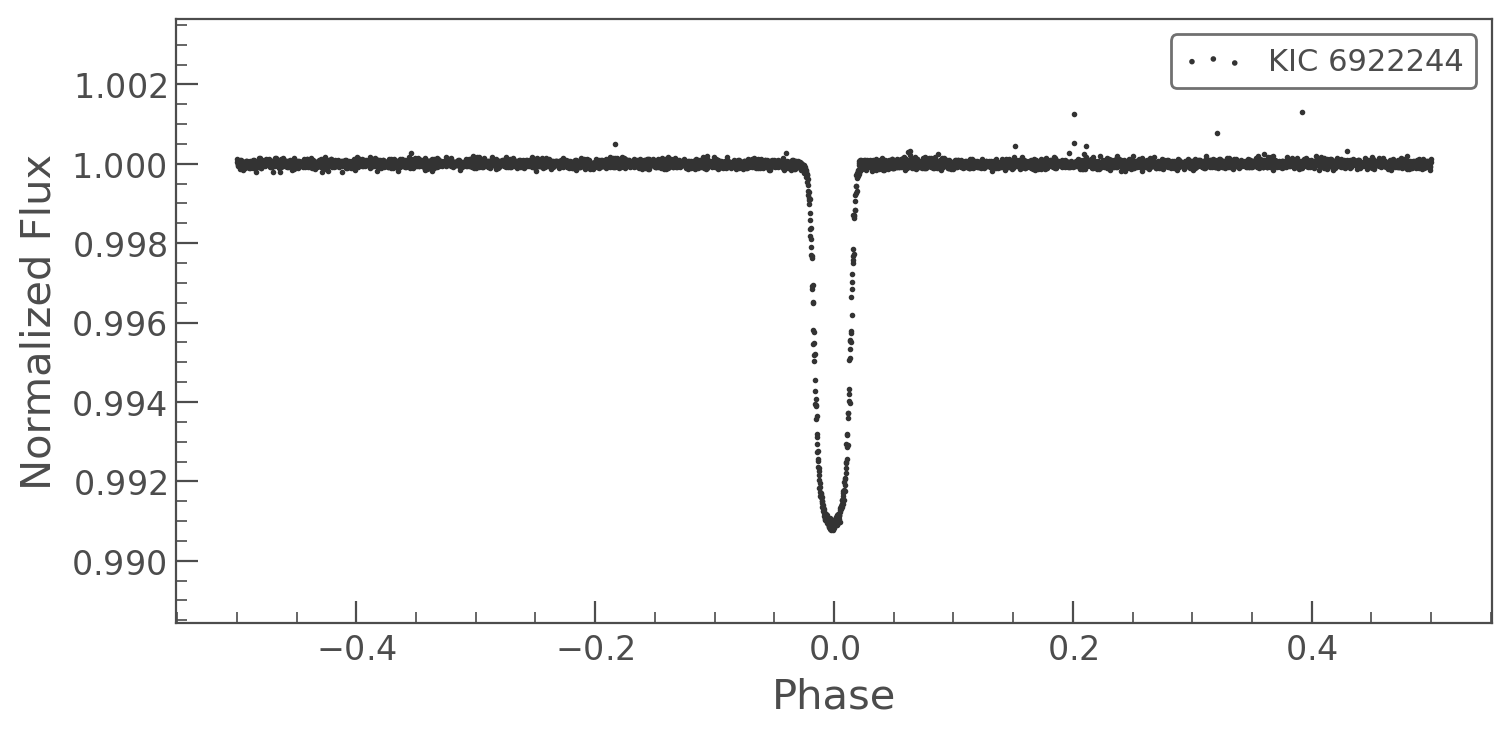

In [10]:
stitched_lc.fold(period=3.52254, t0=1.35).bin().scatter();

Wow!  The high quality transit lightcurve looks almost like a theoretical planet transit model.

Just out of curiosity, we can see what the raw `SAP` flux looks like in comparison by passing a corrector function that returns the raw input lightcurve unchanged.

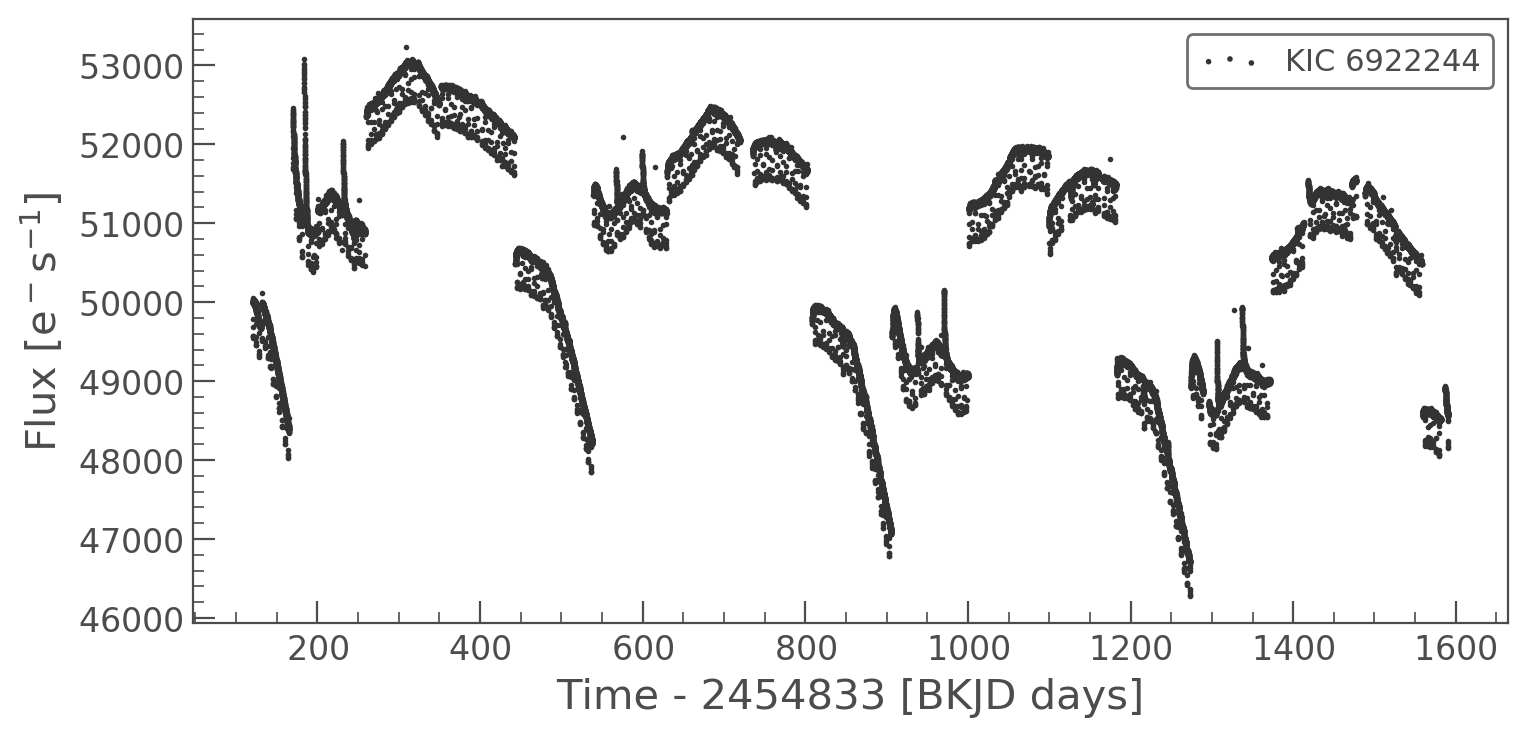

In [12]:
lcfs.SAP_FLUX.stitch(corrector_func=lambda lc:lc).scatter(normalize=False)

The raw simple aperture photometry contains many uncorrected systematic effects.